# Computing temperature-dependent intrinsic parameters (Python interface to UppASD)

In this notebook we show how we can get temperature dependent Ms, A, and K by running spindynamics simulations for a range of temperatures and then fitting the Kuzmin equation to the resulting M(T). From the fit we can get A(T) and K(T).

:::{warning}
In order to keep the runtime for this notebook short, we will use small values for `ncell`, `ip_mcnstep` and `mcnstep`. For production calculations you should choose larger values.
:::

In [1]:
import mammos_analysis
import mammos_dft
import mammos_entity as me
import mammos_spindynamics
import matplotlib.pyplot as plt

## Creating the simulation object

In this notebook we perform simulations for `Fe2.33Ta0.67Y`. First, we need to create a `Simulation` object, which takes care of writing the required inputs and calling UppASD.

We need in total four files for UppASD: `inpsd.dat` as main input file for UppASD as well as three auxiliary files `posfile`, `momfile` and `exchange`. For details about these files as well as UppASD in general refer to the [UppASD documentation](https://uppasd.github.io/UppASD-manual/).

The `Simulation` object can create `inpsd.dat`. It comes with a template suitable for Monte Carlo simulations. We need to pass a number of parameters for this template. For passing these parameters we generally have two options:
1. We can pass them when creating the object.
2. We can pass them later when actually running a simulation.

As a rule of thumb: pass parameters that stay constant for all simulations when creating the object and parameters that vary (e.g. temperature) when running simulations, as we do in this notebook.

For the other three files `posfile`, `momfile` and `exchange` we can use pre-computed data from the database in `mammos_dft`. To access these, we can use the function `get_uppasd_properties`. We get access to the files (including their types in UppASD's nomenclature) as well as the unit cell vectors.

In [2]:
material = "Fe2.33Ta0.67Y"

In [3]:
spindynamics_input = mammos_dft.db.get_uppasd_properties(material)

In [4]:
simulation = mammos_spindynamics.uppasd.Simulation(
    cell=spindynamics_input.cell,
    alat=1e-10,
    ncell=(12, 12, 12),
    posfile=spindynamics_input.posfile,
    posfiletype=spindynamics_input.posfiletype,
    momfile=spindynamics_input.momfile,
    exchange=spindynamics_input.exchange,
    maptype=spindynamics_input.maptype,
    initmag=3,
    ip_mcnstep=100,
    mcnstep=200,
)
simulation

Simulation(
    ncell=(12, 12, 12),
    ip_mcnstep=100,
    mcnstep=200,
    cell=array([[ 5.227483  ,  0.        ,  0.        ],
       [-2.6137415 ,  4.52713308,  0.        ],
       [ 0.        ,  0.        , 25.022642  ]]),
    alat=1e-10,
    posfile=PosixPath('/home/mlang/repos/mammos/mammos-devtools/packages/mammos-dft/src/mammos_dft/data/0007/posfile'),
    posfiletype='D',
    momfile=PosixPath('/home/mlang/repos/mammos/mammos-devtools/packages/mammos-dft/src/mammos_dft/data/0007/momfile'),
    exchange=PosixPath('/home/mlang/repos/mammos/mammos-devtools/packages/mammos-dft/src/mammos_dft/data/0007/exchange'),
    maptype=2,
    initmag=3,
)

## Running a temperature sweep

We now want to run simulations for a series of temperatures between 50 and 900 Kelvin, in steps of 200 Kelvin. We can use the `range` function to get all temperatures. The simulation object provides a method to automatically run all simulations sequentially. By default, each simulation will start with the restart file from the previous simulation. For the first simulation we start with the information from `momfile` (as we have passed `initmag=3` when creating the simulation object).

We have to pass an additional argument `out`, which is the base directory where all simulation output will be written to. The `temperature_sweep` method will create new subdirectories inside that directory. Here, we reuse the `material` string.

In [5]:
coarse_sweep = simulation.temperature_sweep(T=range(50, 900, 200), out=material)

Running simulations for 5 different temperatures:
    [50, 250, 450, 650, 850]
T=50: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/0-run ... simulation finished, took 0:00:06
T=250: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/1-run ... simulation finished, took 0:00:08
T=450: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/2-run ... simulation finished, took 0:00:07
T=650: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/3-run ... simulation finished, took 0:00:08
T=850: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/4-run ... simulation finished, took 0:00:11


The method has returned an object, that allows us to analyze the computed data. For now, we will just create a plot for spontaneous magnetization as a function of temperature:

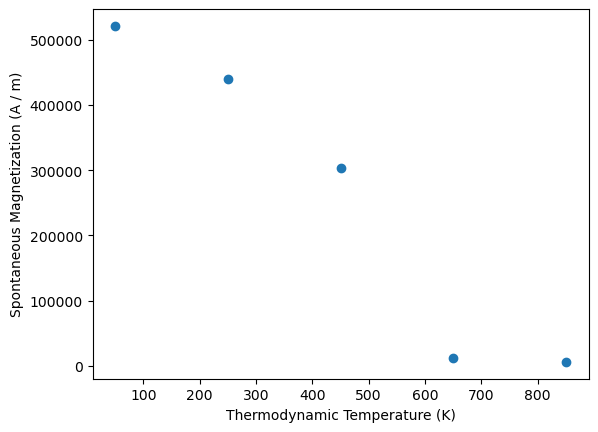

In [6]:
plt.plot(coarse_sweep.T.value, coarse_sweep.Ms.value, "o")
plt.xlabel(coarse_sweep.T.axis_label)
plt.ylabel(coarse_sweep.Ms.axis_label);

From the few simulations we can see that Tc is somewhere between 500 K and 600 K.

## Refining data around Tc

We now run a second sweep with a finer spacing of 40 Kelvin, to better resolve the area around Tc. We can restart the simulation from the result at 450 K, for which we can access the restart file via the `coarse_sweep` object.

In [7]:
simulation.temperature_sweep(
    T=range(490, 650, 40),
    out=material,
    initmag=4,
    restartfile=coarse_sweep.get(T=450).restartfile,
);

Running simulations for 4 different temperatures:
    [490, 530, 570, 610]
T=490: Running UppASD in Fe2.33Ta0.67Y/1-temperature_sweep/0-run ... simulation finished, took 0:00:10
T=530: Running UppASD in Fe2.33Ta0.67Y/1-temperature_sweep/1-run ... simulation finished, took 0:00:08
T=570: Running UppASD in Fe2.33Ta0.67Y/1-temperature_sweep/2-run ... simulation finished, took 0:00:08
T=610: Running UppASD in Fe2.33Ta0.67Y/1-temperature_sweep/3-run ... simulation finished, took 0:00:08


## Analyzing simulation output

We will now analyze the data in more detail. We can use the function `uppasd.read` to (lazily) load all data. We can point it to the base directory where we have stored all simulations and we will get access to the sweeps and the individual runs of these sweeps.

In [8]:
data = mammos_spindynamics.uppasd.read(material)
data

MammosUppasdData('Fe2.33Ta0.67Y')

The returned object has an `info` method, which we can use to get a first overview of the simulations we have performed:

In [9]:
data.info()

,name,description,time_elapsed,T,initmag,restartfile
0,0-temperature_sweep,,None,"[50, 250, 450, 650, 850]",NaN,NaN
1,1-temperature_sweep,,None,"[490, 530, 570, 610]",4.0,Fe2.33Ta0.67Y/0-temperature_sweep/2-run/restar...


We can access individual sweeps either by index or using the `get` method with unique metadata, e.g. the name:

In [10]:
coarse_sweep = data[0]  # same object as the return value in cell 5
coarse_sweep.info()

,name,description,time_elapsed,T,initmag,restartfile
0,0-run,,0:00:06,50,NaN,NaN
1,1-run,,0:00:08,250,4.0,Fe2.33Ta0.67Y/0-temperature_sweep/0-run/restar...
2,2-run,,0:00:07,450,4.0,Fe2.33Ta0.67Y/0-temperature_sweep/1-run/restar...
3,3-run,,0:00:08,650,4.0,Fe2.33Ta0.67Y/0-temperature_sweep/2-run/restar...
4,4-run,,0:00:11,850,4.0,Fe2.33Ta0.67Y/0-temperature_sweep/3-run/restar...


In [11]:
fine_sweep = data.get(name="1-temperature_sweep")
fine_sweep.info()

,name,description,time_elapsed,T,initmag,restartfile
0,0-run,,0:00:10,490,4,Fe2.33Ta0.67Y/0-temperature_sweep/2-run/restar...
1,1-run,,0:00:08,530,4,Fe2.33Ta0.67Y/1-temperature_sweep/0-run/restar...
2,2-run,,0:00:08,570,4,Fe2.33Ta0.67Y/1-temperature_sweep/1-run/restar...
3,3-run,,0:00:08,610,4,Fe2.33Ta0.67Y/1-temperature_sweep/2-run/restar...


For further analysis we create new entities combining T and Ms for the coarse and fine sweep respectively. (Note, that these are not ordered by temperature.)

In [12]:
T_combined = me.concat_flat(coarse_sweep.T, fine_sweep.T)
Ms_combined = me.concat_flat(coarse_sweep.Ms, fine_sweep.Ms)

We can plot the combined simulation results:

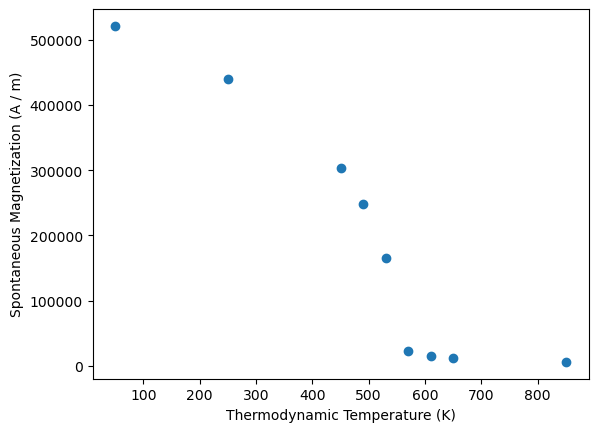

In [13]:
plt.plot(T_combined.value, Ms_combined.value, "o")
plt.xlabel(T_combined.axis_label)
plt.ylabel(Ms_combined.axis_label);

For this material pre-computed values for Ms are available in the database in `mammos_spindynamics`. We can compare the our data against the database to get a feeling for the accuracy we can get with the few Monte Carlo steps we performed:

In [14]:
db_values = mammos_spindynamics.db.get_spontaneous_magnetization(chemical_formula=material)

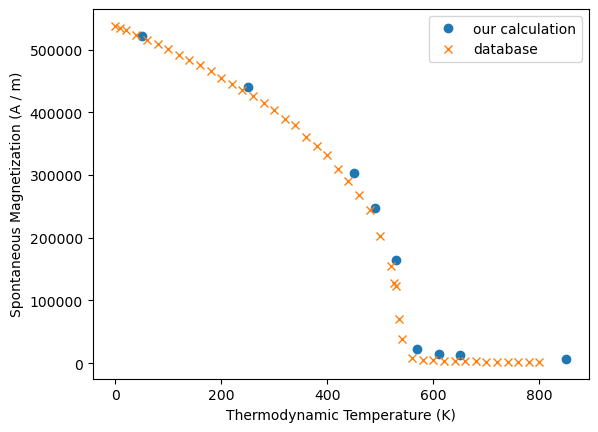

In [15]:
plt.plot(T_combined.value, Ms_combined.value, "o", label="our calculation")
db_values.plot(ax=plt.gca(), label="database");

Despite the few samples we are relatively close to the data provided in the database.

## Kuzmin fit

We can now pass the data from the temperature sweep to the Kuzmin function in `mammos_analysis`:

In [16]:
results_kuzmin = mammos_analysis.kuzmin.kuzmin_properties(T=T_combined, Ms=Ms_combined)

We can compare the fit against our data:

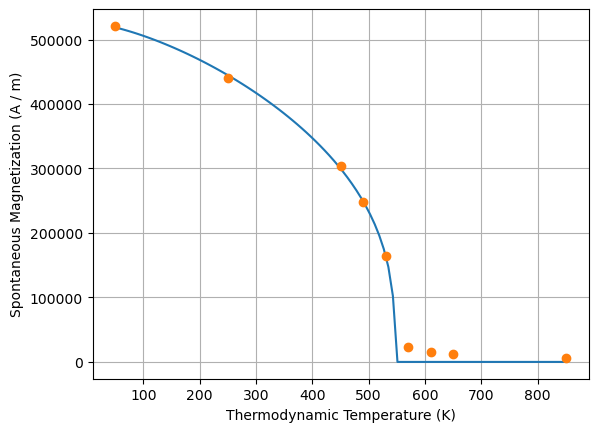

In [17]:
results_kuzmin.Ms.plot()
plt.plot(T_combined.value, Ms_combined.value, "o");

From the Kuzmin fit we can get an estimate for Tc. Again, we can compare this estimate against the one obtained by fitting to the data from the database.

In [18]:
print("Our simulation:", results_kuzmin.Tc)
print("From database: ", mammos_analysis.kuzmin_properties(T=db_values.T, Ms=db_values.Ms).Tc)

Our simulation: CurieTemperature(value=547.0103293988091, unit=K)
From database:  CurieTemperature(value=537.1888739137271, unit=K)


As a next step we could use results from the Kuzmin fit as inputs for a micromagnetic simulation. Using the fit, we can compute parameters for any temperature. E.g. to get parameters at 300 Kelvin (for which we did not run a simulation) we can use:

In [19]:
results_kuzmin.Ms(300)

Entity(ontology_label='SpontaneousMagnetization', value=np.float64(417178.2716455301), unit='A / m')

In [20]:
results_kuzmin.A(300)

Entity(ontology_label='ExchangeStiffnessConstant', value=np.float64(1.720119513984039e-12), unit='J / m')

If you are interested in performing micromagnetic simulations with these parameters you could continue with the [hard magnet tutorial](hard-magnet-tutorial.ipynb#Run-micromagnetic-simulation-to-compute-hysteresis-loop).